Bibliography:

[1] [@bank2021autoencoders]: Dor Bank, Noam Koenigstein, and Raja Giryes. "Autoencoders." arXiv preprint arXiv:2003.05991 (2021).


# Visualising data with Autoencoders and Variational Autoencoders

### 1. FMNIST preparation

First download dataset from github.
https://github.com/zalandoresearch/fashion-mnist

I recommend to clone their repository (Best to do that outside of your local repo)
It will also provide us with loading functions

git clone https://github.com/zalandoresearch/fashion-mnist.git   

If cloned images/labels should be in fashion-mnist\data\fashion


In [42]:
import sys
#set your path to the fashion-mnist/utils folder
sys.path.append('../fashion-mnist/utils')
import mnist_reader


In [43]:
X_train, y_train = mnist_reader.load_mnist('../fashion-mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('../fashion-mnist/data/fashion', kind='t10k')

In [44]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


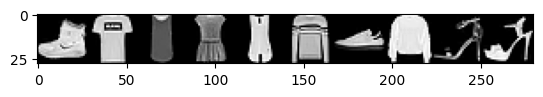

In [45]:
#show first 10 images 
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.hstack(X_train[:10].reshape(10,28,28)), cmap='gray')

In [46]:
X_train.min(), X_train.max()


(0, 255)

Lets normalize data to 0,1

In [47]:
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()


### 2. Autoencoders 
Network trained to reduce number of dimmensions in data while perserving minimal reconstruction loss of information.
It's composed of 2 layers where one compresses and second one decompresses input data. While both compresser and decompresser are trained silmutainously they minimise loss of information after that 2 procedures. 

   - Zastosowania Autoencoderów


Dimensionality Reduction (reducing number of dimmensions of input data)

- It can be used as lossy Image/Audio Compression 
- even as substitute of methods like TSNE to compress numerical data into 2/3 dimmensions to plot them.

Image Denoising - AE can be trained to recover data from noised verision (ex. Variational AutoEncoder)

Variational Autoencoder about which will be next section can also be used for generative modeling.

    




   - Model explanation (encoding - decoding)


![
    Autoencoder model architecture from [1] [@bank2021autoencoders]
](aemodel.png)
 
 Autoencoder model architecture from [1] [@bank2021autoencoders]

Autoencoders are models that are composed of 2 sections: Encoding layer, Decoding layer.


Both are simple dense layers where encoding should be of size:

`INPUT_SIZE` -> `LATENT SPACE SIZE`

where if we want it to encode, `LATENT SPACE` should be smaller than `INPUT_SIZE`. On its own, if we pass data through a layer that gives a smaller output, we will receive less information. That reduced form, which we will denote as `R`:

Input -> `ENCODER` -> Reduced representation `R`

That reduced output goes now to the second layer, which is `DECODER`. The decoder does the inverse mechanism. It will be a dense layer that should, as input, take 

`LATENT SPACE SIZE` data and transform it back to `INPUT_SIZE` data.

`INPUT_SIZE` -> `LATENT SPACE SIZE` -> `LATENT SPACE SIZE` -> `INPUT_SIZE`


In [48]:
#show size of input data
print(X_train.shape)

(60000, 784)


`INPUT SIZE` is 784

As `LATENT SPACE SIZE` we need something smaller and for this to be visualisable lets keep it square: for example 20*20 = 400


So in summary
ENCODER:

- Dense layer (INPUT_SIZE -> LATENT)
- Activation function ( sigmoid best as it gives output in 0-1)

->

DECODER:

- Dense layer (LATENT -> INPUT_SIZE)
- Activation function ( sigmoid best as it gives output in 0-1)


In [49]:

INPUT_SIZE = 28*28
LATENT_SPACE_SIZE = 20*20
LATENT_SPACE_SIDE = 20

In [65]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_size = INPUT_SIZE, latent_space_size = LATENT_SPACE_SIZE):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size,input_size//2),
            nn.ReLU(),
            nn.Linear(input_size//2,latent_space_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_space_size, input_size//2),
            nn.ReLU(),
            nn.Linear(input_size//2, input_size),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        return self.encoder(x)
    def decode(self, x):
        return self.decoder(x)
    
    def loss_calculation(self, recon_x, x, loss_func):
        loss = loss_func(recon_x, x)
        return loss

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### training

Having a way to compress and decompress data now it's time to direct this mechanism into better results.
As the cost function we will calculate difference between input_image and output after encoding and decoding.
Our goal is to train encoder and decoding layer is mostly used for training so that we are able to compare output with input.

A -> encode -> B -> decode -> C

    cost = abs( A - C ) loss of information which we want to minimalize

Knowing what we want from our cost function we will use MSE: 
mean square error which will look like this:

    cost = mean( (A - C)^2 )

In [66]:
def cost_function(recon_x, x):
    MSE = nn.MSELoss()
    return MSE(recon_x, x)

Before training let's also prepare function that will allow us to preview image in reduced representation, to validate empirically our progress.

In [67]:
import torch

def sample(model, test_samples):
    model.eval()
    with torch.no_grad():
        return model(test_samples)
    
def preview_samples( samples, image_shape=(28,28) ):
    plt.imshow(np.hstack(samples.reshape(-1 ,image_shape[0], image_shape[1])))
    plt.show()

In [68]:
def train_ae_variations(model, data, epochs=5, learning_rate=1e-4, plot_2d_latent = False, plot_decompressed = False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    for i in range(epochs):
        batch_loss = 0
        for batch in data:
            optimizer.zero_grad()
            recon_batch = model(batch)
            loss = model.loss_calculation(recon_batch, batch, cost_function)
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        loss_history.append(batch_loss/len(data))
        print(f'Epoch {i} Loss: {loss.item()}')
        if(plot_2d_latent):
            compressed_samples = model.encode(X_test.view(-1, INPUT_SIZE)).detach().numpy()
            plt.scatter(compressed_samples[:,0], compressed_samples[:,1], c=y_test, cmap='tab10')
            plt.colorbar()
            plt.show()
            
            
        if(plot_decompressed):
            sample_data = X_test[:10].view(-1, INPUT_SIZE)
            print('Original samples')
            preview_samples(sample_data)
            print("Compressed samples")
            compressed_samples = model.encode(sample_data).detach().numpy()
            preview_samples(compressed_samples, image_shape=(LATENT_SPACE_SIDE, LATENT_SPACE_SIDE))
            print('Reconstructed samples')
            reconstructed_samples = model.decode(torch.tensor(compressed_samples)).detach().numpy()
            preview_samples(reconstructed_samples)    
    return loss_history

In [69]:
#split training data into batches
EPOCHS = 5
BATCH_SIZE = 120
LEARNING_RATE = 1e-4

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
batched_data = torch.utils.data.DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True)
#convert to float32



E:\Users\qesterius\AppData\Local\Temp\ipykernel_14596\581915199.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
E:\Users\qesterius\AppData\Local\Temp\ipykernel_14596\581915199.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


Epoch 0 Loss: 0.027898909524083138
Original samples


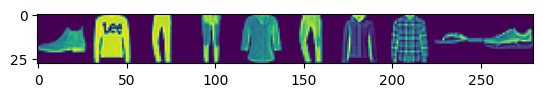

Compressed samples


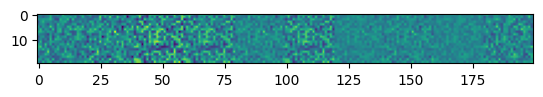

Reconstructed samples


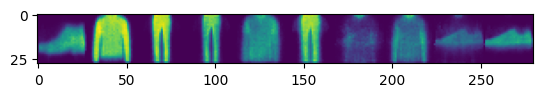

Epoch 1 Loss: 0.02184395305812359
Original samples


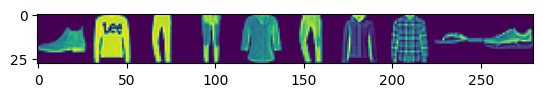

Compressed samples


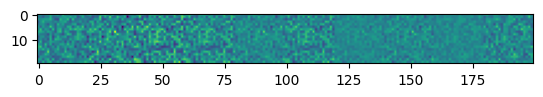

Reconstructed samples


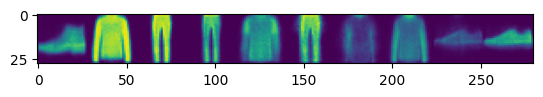

Epoch 2 Loss: 0.02070830948650837
Original samples


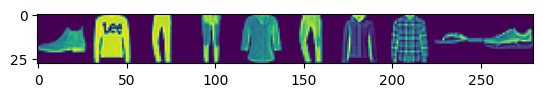

Compressed samples


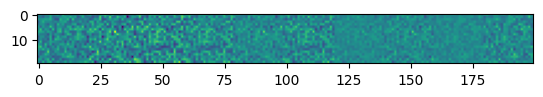

Reconstructed samples


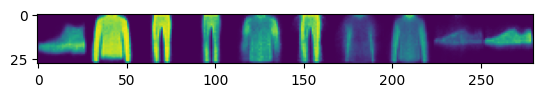

Epoch 3 Loss: 0.016183990985155106
Original samples


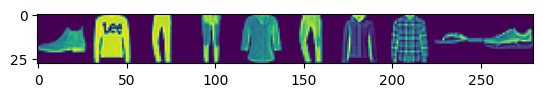

Compressed samples


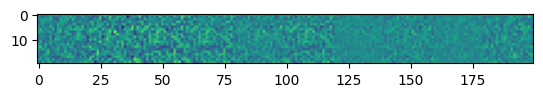

Reconstructed samples


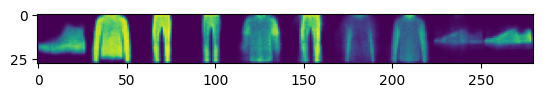

Epoch 4 Loss: 0.015666494145989418
Original samples


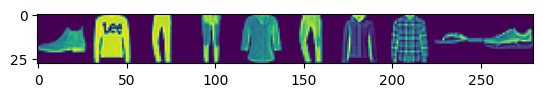

Compressed samples


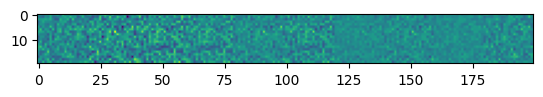

Reconstructed samples


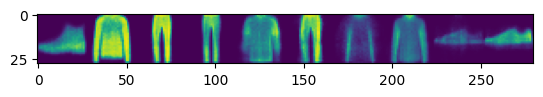

In [70]:
ae = Autoencoder()
loss_history = train_ae_variations(ae, batched_data, epochs=EPOCHS, learning_rate=LEARNING_RATE, plot_decompressed=True)



   - Encoding to 2 dimensions and plotting.

   We can use it to visualize data as point in embedded space. Each image will be converted into 2 dimmensional point (2 values).

In [71]:
def plot_2d_representation(x, y):
    plt.scatter(x[:,0],x[:,1] , c=y, cmap='tab10')
    plt.colorbar()
    plt.show()
    

In [72]:
def preview_encoding_decoding_2d(model, samples, labels):
    sample_data = samples.view(-1, INPUT_SIZE)
    print('Original samples')
    preview_samples(sample_data)
    print("Compressed samples")
    compressed_samples = model.encode(sample_data).detach().numpy()
    plot_2d_representation(compressed_samples, labels)
    print('Reconstructed samples')
    reconstructed_samples = model.decode(torch.tensor(compressed_samples)).detach().numpy()
    preview_samples(reconstructed_samples)

Epoch 0 Loss: 0.04441589489579201


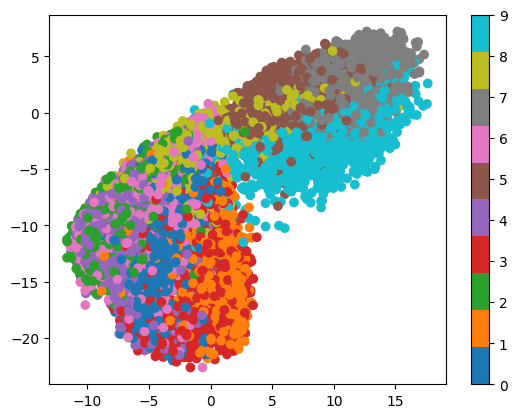

Epoch 1 Loss: 0.03905036672949791


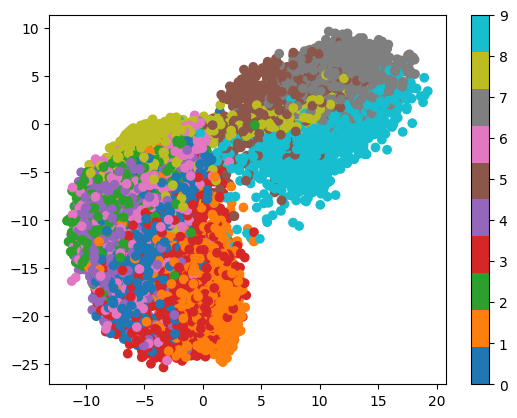

Epoch 2 Loss: 0.03304830566048622


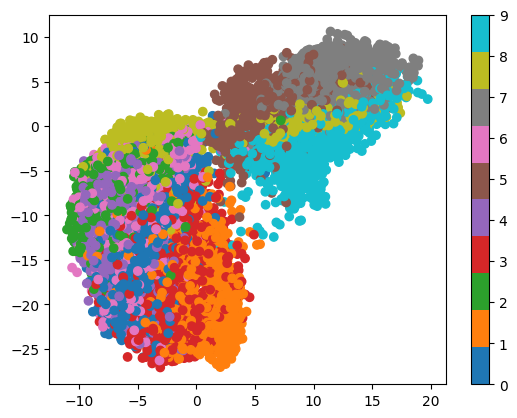

Epoch 3 Loss: 0.03216833621263504


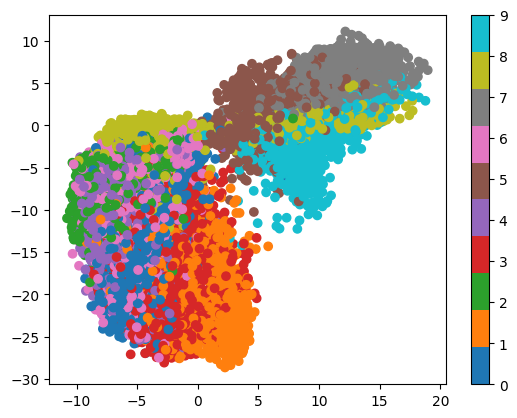

Epoch 4 Loss: 0.03178131580352783


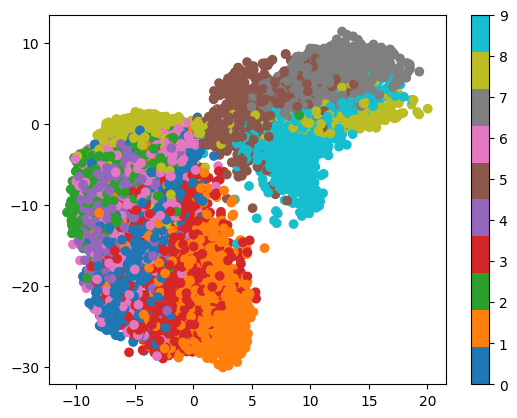

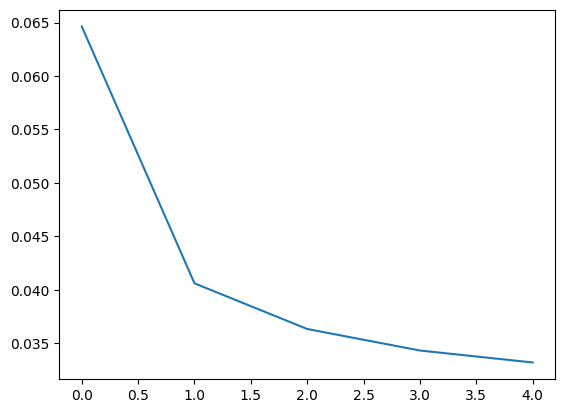

Autoencoder
Original samples


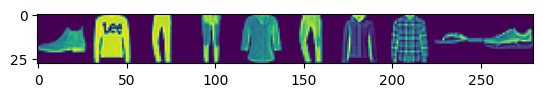

Compressed samples


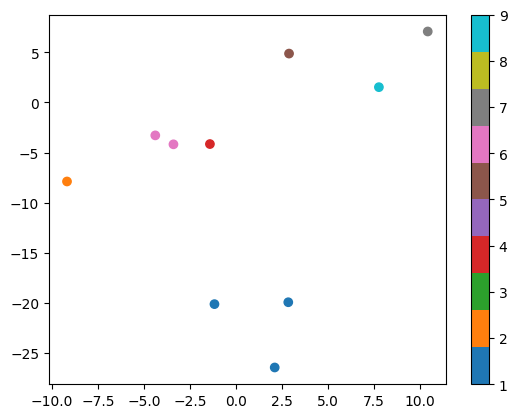

Reconstructed samples


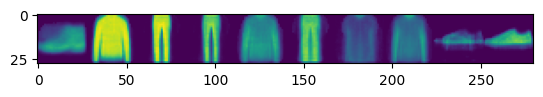

In [73]:
ae = Autoencoder(latent_space_size=2)
loss_history = train_ae_variations(ae, batched_data, epochs=5, plot_2d_latent=True)
plt.plot(loss_history)
plt.show()    
    
print('Autoencoder')
preview_encoding_decoding_2d(ae, X_test[:10], y_test[:10])


### 3. Variational Autoencoder 
   - Model explanation 
   - Mathematical formulas for noise injection 
   - Encoding to 2 dimensions and plotting
   - Probkowanie fantazji sieci


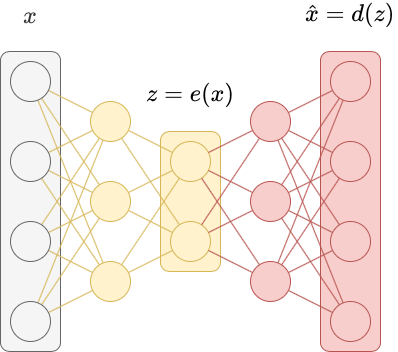

In [77]:
#Variational Autoencode
class VariationalEncoder(nn.Module):
    def __init__(self, input_size, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(INPUT_SIZE, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        #self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = torch.nn.functional.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = 0.5 * torch.sum(sigma.pow(2) + mu.pow(2) - torch.log(sigma) - 1, dim=1).mean()
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size = INPUT_SIZE, latent_space_size = LATENT_SPACE_SIZE):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_size, latent_space_size)
        self.decoder = nn.Sequential(
            nn.Linear(latent_space_size, input_size//2),
            nn.ReLU(),
            nn.Linear(input_size//2, input_size),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)
    def decode(self, x):
        return self.decoder(x)
    
    def loss_calculation(self, recon_x, x, loss_func):
        loss = loss_func(recon_x, x) + self.encoder.kl
        return loss
    
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    


torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])


torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

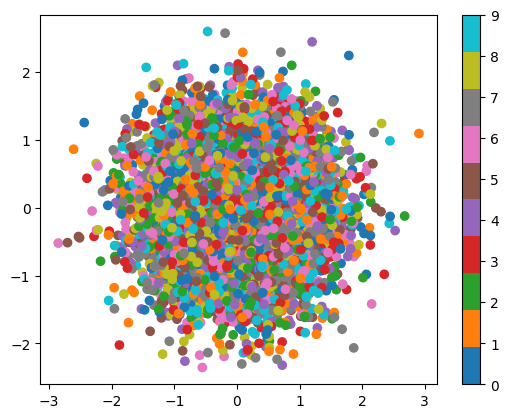

torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

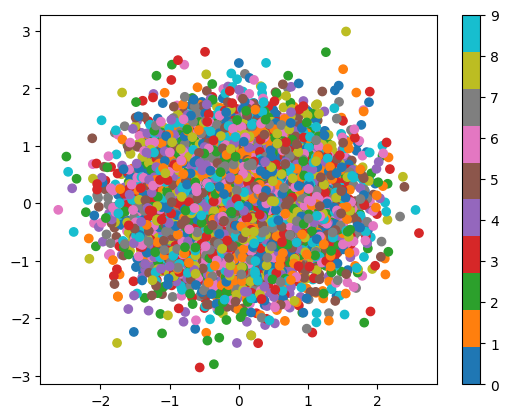

torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

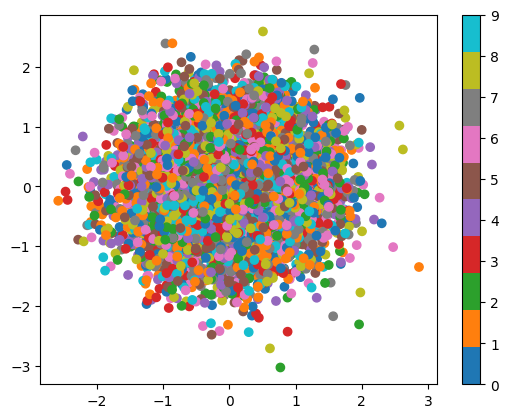

torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

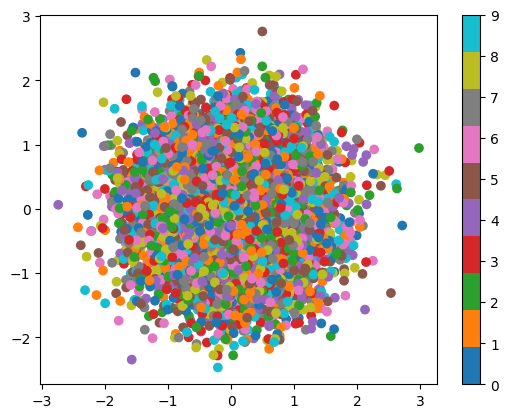

torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

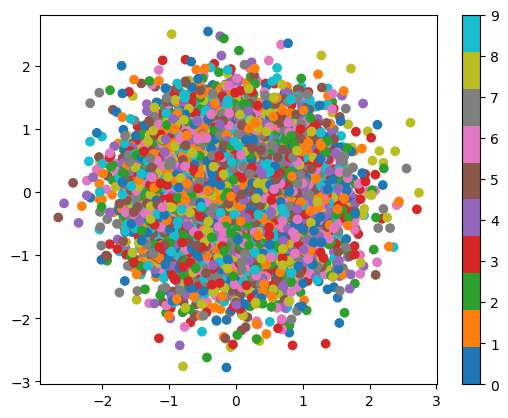

torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

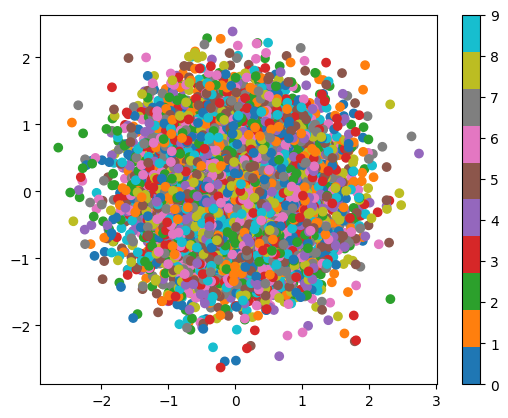

torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

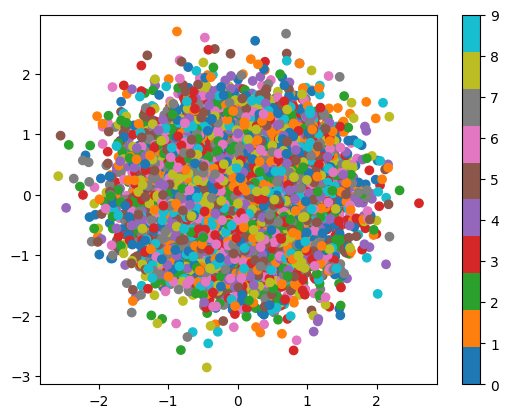

torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

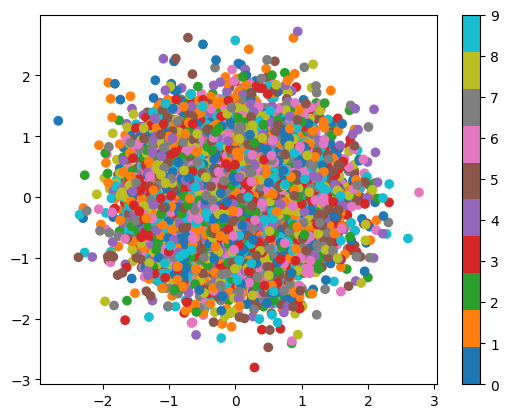

torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

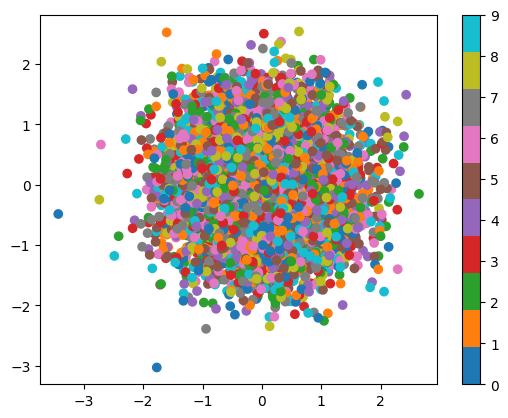

torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

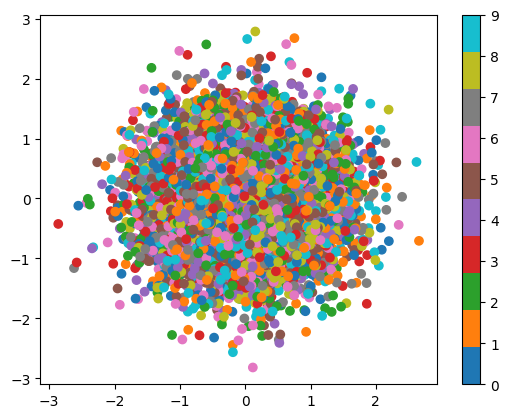

torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

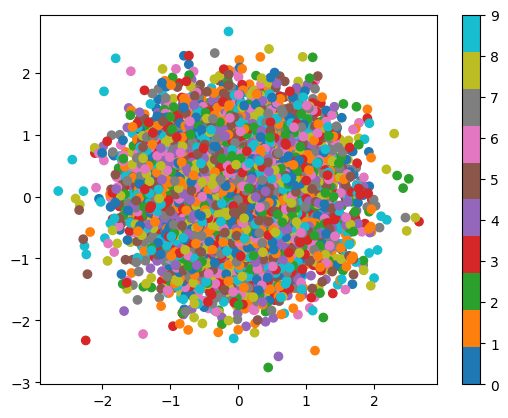

torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size([120, 784])
torch.Size(

In [78]:
#print learning curve
vae = VariationalAutoencoder(latent_space_size=2)
loss_history = train_ae_variations(vae, batched_data, epochs=20, plot_2d_latent=True, learning_rate=1e-2)
plt.plot(loss_history)
plt.show()    
    
print('VariationalAutoencoder')
preview_encoding_decoding_2d(ae, X_test[:10], y_test[:10])

### 4. Porównanie dwóch metod
